## Human Protein Atlas Image Classification (Kaggle Project)
In this Kaggle project, I developed a model to classify mixed patterns of proteins in microscope images. There are 28 different target proteins and multiple proteins can appear in the same image, making it a multilabel classification task. I aimed to use relatively simple, easy-to-train deep convolutional neural network model to achive as high precision as possible.

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image
import cv2
from sklearn.utils import class_weight, shuffle
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
SIZE = 299

### 1 Input data processing
Image data were presented in four channels: green - protein of interest; blue - nucleus; red - micortubules; yellow - endoplasmic reticulum

Load dataset information and define image data generator as follow:
1. cell image has 4 channels (RGBY), put target protein channel at green, combine R+Y and B+Y to the remaining two
2. resize 512x512 image to 299x299. Step 1 and 2 allows one to use a pretrained model in Keras
3. data augmentation by one of (rotate 0,90,180,270 degree, flipping left-right, flipping up-down)

In [2]:
path_to_train = 'data/train/'
data = pd.read_csv('data/train.csv')

train_dataset_info = []
for name, labels in zip(data['Id'], data['Target'].str.split(' ')):
    train_dataset_info.append({
        'path':os.path.join(path_to_train, name),
        'labels':np.array([int(label) for label in labels])})
train_dataset_info = np.array(train_dataset_info)

class data_generator:
    
    def create_train(dataset_info, batch_size, shape, augument=True):
        assert shape[2] == 3
        while True:
            dataset_info = shuffle(dataset_info)
            for start in range(0, len(dataset_info), batch_size):
                end = min(start + batch_size, len(dataset_info))
                batch_images = []
                X_train_batch = dataset_info[start:end]
                batch_labels = np.zeros((len(X_train_batch), 28))
                for i in range(len(X_train_batch)):
                    image = data_generator.load_image(
                        X_train_batch[i]['path'], shape)   
                    if augument:
                        image = data_generator.augment(image)
                    batch_images.append(image/255.)
                    batch_labels[i][X_train_batch[i]['labels']] = 1
                yield np.array(batch_images, np.float32), batch_labels

    def load_image(path, shape):
        image_red_ch = Image.open(path+'_red.png')
        image_yellow_ch = Image.open(path+'_yellow.png')
        image_green_ch = Image.open(path+'_green.png')
        image_blue_ch = Image.open(path+'_blue.png')
        image = np.stack((
        (np.array(image_red_ch)+np.array(image_yellow_ch))/2, 
        np.array(image_green_ch), 
        (np.array(image_blue_ch)+np.array(image_yellow_ch))/2), -1)
        image = cv2.resize(image, (shape[0], shape[1]))
        return image

    def augment(image):
        augment_img = iaa.Sequential([
            iaa.OneOf([
                iaa.Affine(rotate=0),
                iaa.Affine(rotate=90),
                iaa.Affine(rotate=180),
                iaa.Affine(rotate=270),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5),
            ])], random_order=True)

        image_aug = augment_img.augment_image(image)
        return image_aug

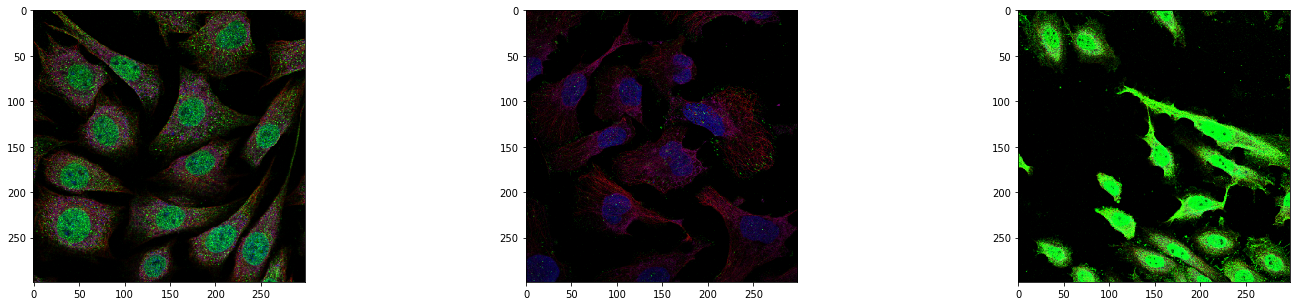

In [36]:
sample_gen = data_generator.create_train(
    train_dataset_info, 3, (SIZE,SIZE,3), augument=False)
images , labels = next(sample_gen)
fig, ax = plt.subplots(1,3,figsize=(25,5))
for i in range(3):
    ax[i].imshow(images[i])

### 2 Exploratory data analysis
Before doing any modeling, the first step is to know the data set better. Here I have computed some basic statistics of the training data set to provide an overview of the data.

In [20]:
#helper codes
label_names = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

reverse_train_labels = dict((v,k) for k,v in label_names.items())

def fill_targets(row):
    row.Target = np.array(row.Target.split(" ")).astype(np.int)
    for num in row.Target:
        name = label_names[int(num)]
        row.loc[name] = 1
    return row

#append data frame with 'one-hot' matrix,  for class visualization
for key in label_names.keys():
    data[label_names[key]] = 0
data = data.apply(fill_targets, axis=1)
target_counts = data.drop(["Id", "Target"],axis=1).sum(axis=0).sort_values(ascending=False)

data["number_of_targets"] = data.drop(["Id", "Target"],axis=1).sum(axis=1)
count_perc = np.round(100 * data["number_of_targets"].value_counts() / data.shape[0], 2)

Simple explorations of the data showed that majority of the classes have very few positive samples. This should be taken care when training the prediction model.

Number of training samples: 31072


Text(0.5,1,'Number of labels statistics')

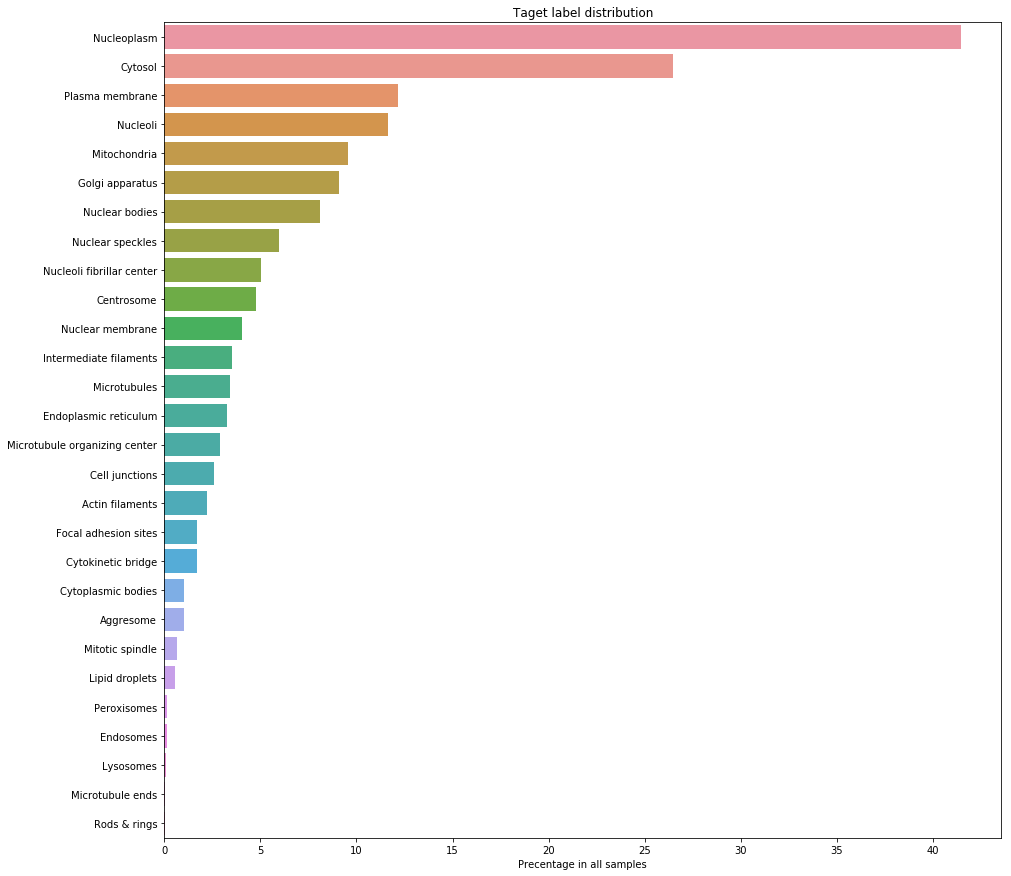

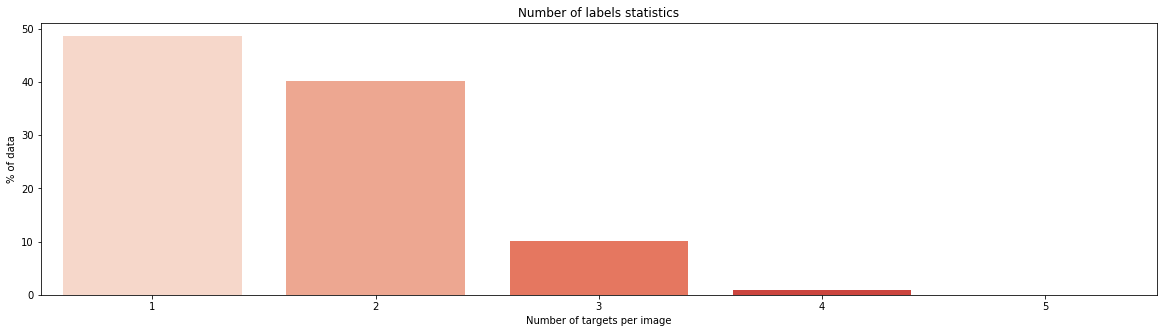

In [27]:
Ns = train_dataset_info.shape[0]
print('Number of training samples:',Ns)

plt.figure(figsize=(15,15))
sns.barplot(y=target_counts.index.values, x=target_counts.values/Ns*100, order=target_counts.index)
plt.xlabel('Precentage in all samples')
plt.title('Taget label distribution')

plt.figure(figsize=(20,5))
sns.barplot(x=count_perc.index.values, y=count_perc.values, palette="Reds")
plt.xlabel("Number of targets per image")
plt.ylabel("% of data")
plt.title('Number of labels statistics')

### 3 Model training and prediction
To allow fast and accurate prediction of the cell labels, I applied transfer learning using a pretrained InceptionNetV3 deep convolutional neural network. The top few layers were retrained to build a 28-class classifier for the current purpose. (output size: 8x8x2048 -> 28)

![InceptionV3](https://cloud.google.com/tpu/docs/images/inceptionv3onc--oview.png)

Also, a standard cross-entropy loss may not work well in this problem due to class imbalance. I implemented focal loss (Lin et al. 2017) to improve the final prediction. The idea is to penalize more on poorly-classified examples.

\begin{equation*}
FL(p_t) = -(1-p_t)^{\gamma}log(p_t)
\end{equation*}
, $p_t$ is the class prediction probability, $\gamma$ is a hyper-parameter chosen to be 2.0 in Lin et al.

Model performance will be evaluated using F1 score, which is the harmonic mean of precision and recall.

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D, BatchNormalization, Input, Conv2D
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import keras
from keras.models import Model
import tensorflow as tf

# define model, load InceptionV3 net from Keras, 
# connect to a 1x1 conv2D layer and then to dense 1024, finally to a 28-node classifers    
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = InceptionV3(include_top=False,
                   weights='imagenet',
                   input_shape=input_shape)
    bn = BatchNormalization()(input_tensor)
    x = base_model(bn)
    x = Conv2D(32, kernel_size=(1,1), activation='relu')(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(n_out, activation='sigmoid')(x)
    model = Model(input_tensor, output)
    
    return model

# define f1 score for model evaluation
def f1_threshold(y_true, y_pred,p):
    y_pred = np.where(y_pred > p, 1, 0)
    tp = np.sum(y_true*y_pred,axis=-1)
    fp = np.sum((1-y_true)*y_pred,axis=-1)
    fn = np.sum(y_true*(1-y_pred),axis=-1)
     
    p = tp/(tp+fp+1e-7)
    r = tp/(tp+fn+1e-7)
     
    f1 = 2*p*r / (p+r+1e-7)
    f1 = np.where(np.isnan(f1),0,f1)
    return np.mean(f1)

model = create_model(
    input_shape=(SIZE,SIZE,3), 
    n_out=28)

Using TensorFlow backend.


Here is the code for trainig the model. Training was divided into two steps, 1. keep all layers from InceptionNet frozen, training just the last few layers; 2. unlock all layers to fine-tune the parameters from pre-trained network

In [ ]:
# create callbacks list
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

epochs = 100; batch_size = 16
checkpoint = ModelCheckpoint('models/InceptV3-4C-focalloss.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                                   verbose=1, min_lr=1e-6, mode='auto', epsilon=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10)

# create focal loss function
def focal_loss(gamma=2., alpha=.25):
    #default paramemters in Lin et al. (2017)
    def focal_loss_eval(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        _epsilon = tf.convert_to_tensor(1e-7,dtype=pt_1.dtype.base_dtype)
        pt_1 = tf.clip_by_value(pt_1,_epsilon,1-_epsilon)
        pt_0 = tf.clip_by_value(pt_0,_epsilon,1-_epsilon)
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_eval

# evaluate model by marco-averaging F1 score
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred,'float'),axis=-1)
    fp = K.sum(K.cast((1-y_true)*y_pred,'float'),axis=-1)
    fn = K.sum(K.cast(y_true*(1-y_pred),'float'),axis=-1)
    
    p = tp/(tp+fp+K.epsilon())
    r = tp/(tp+fn+K.epsilon())
    
    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1),tf.zeros_like(f1),f1)
    return K.mean(f1)

callbacks_list = [checkpoint, early, reduceLROnPlat]

# split data into train, valid
indexes = np.arange(train_dataset_info.shape[0])
np.random.shuffle(indexes)
train_indexes, valid_indexes = train_test_split(indexes, test_size=0.15, random_state=8)

# create train and valid datagens
train_generator = data_generator.create_train(
    train_dataset_info[train_indexes], batch_size, (SIZE,SIZE,3), augument=True)
validation_generator = data_generator.create_train(
    train_dataset_info[valid_indexes], 32, (SIZE,SIZE,3), augument=False)

# warm up model
model = create_model(
    input_shape=(SIZE,SIZE,3), 
    n_out=28)

for layer in model.layers:
    layer.trainable = False
model.layers[-1].trainable = True
model.layers[-2].trainable = True
model.layers[-3].trainable = True
model.layers[-4].trainable = True
model.layers[-5].trainable = True
model.layers[-6].trainable = True

model.compile(
    loss=[focal_loss(gamma=2.0,alpha=0.5)], 
    optimizer=Adam(1e-03),
    metrics=[f1])

model.fit_generator(
    train_generator,
    steps_per_epoch=np.ceil(float(len(train_indexes)) / float(batch_size)),
    validation_data=validation_generator,
    validation_steps=np.ceil(float(len(valid_indexes)) / float(batch_size)),
    epochs=2, 
    verbose=2)

# train all layers 
for layer in model.layers:
    layer.trainable = True
model.compile(loss=[focal_loss(gamma=2.0,alpha=0.5)],
            optimizer=Adam(1e-04),
            metrics=[f1])
history = model.fit_generator(
    train_generator,
    steps_per_epoch=np.ceil(float(len(train_indexes)) / float(batch_size)),
    validation_data=validation_generator,
    validation_steps=np.ceil(float(len(valid_indexes)) / float(batch_size)),
    epochs=epochs, 
    verbose=2,
    callbacks=callbacks_list)
# save model performance over training epoches
np.save('prediction/loss_InceptV3-4C-focalloss.npy',history.history["loss"])
np.save('prediction/valloss_InceptV3-4C-focalloss.npy',history.history["val_loss"])

#calculation prediction on validation set
F1_val = 0
predictions = pd.DataFrame({'Id':[] , 'Target' : [], 'Predict' : [], 'F1' : []})

for i in valid_indexes:
    path = train_dataset_info[i]['path']
    image = data_generator.load_image(path, (SIZE,SIZE,3))/255.
    score_predict = model.predict(image[np.newaxis])[0]
    labels = np.zeros((28,))
    labels[train_dataset_info[i]['labels']] = 1
    f1 = (f1_threshold(labels,score_predict,0.4))
    F1_val += f1
    predictions = predictions.append({'Id' : path, 'Target' : labels, 'Predict': np.where(score_predict > 0.4, 1, 0), 'F1' : f1}, ignore_index=True)
print('Validation F1 score: ',F1_val/len(valid_indexes))
predictions.to_csv('prediction/InceptionV3-4C-validation.csv')

For the sake of time, I will load a model that has been trained for 30 epoches using a focal loss function.

Validation F1 score:  0.8276433289431173


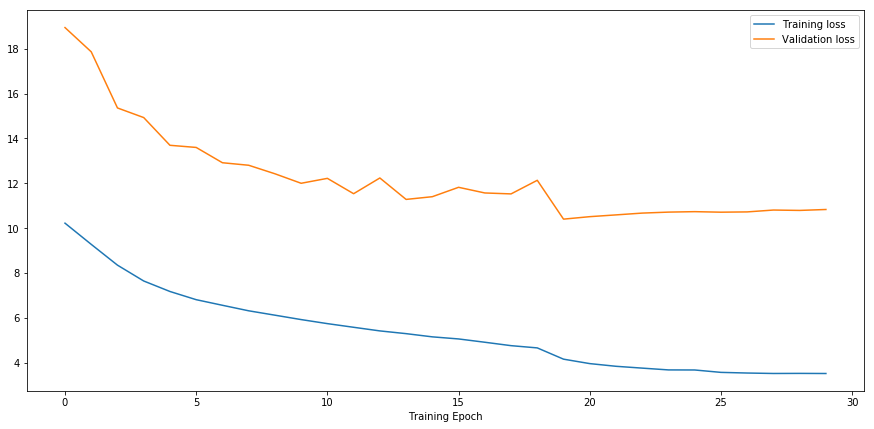

In [17]:
from sklearn.model_selection import train_test_split

# split data into training set (85%), validation set (15%)
indexes = np.arange(train_dataset_info.shape[0])
np.random.shuffle(indexes)
train_indexes, valid_indexes = train_test_split(indexes, test_size=0.15, random_state=8)

model.load_weights('models/InceptV3-4C-focalloss.h5')
loss = np.load("prediction/loss_InceptV3-4C-focalloss.npy")
val = np.load("prediction/valloss_InceptV3-4C-focalloss.npy")

#plot training loss and validation loss
plt.figure(figsize=(15,7))
plt.plot(np.arange(loss.shape[0]), loss, label="Training loss")
plt.plot(np.arange(val.shape[0]), val, label="Validation loss")
plt.legend()
plt.xlabel('Training Epoch')

predictions = pd.read_csv('prediction/InceptionV3-4C-validation.csv')
print('Validation F1 score: ',predictions['F1'].mean())

### 4 Visualization of miss-classified samples

Let's look at the prediction accuracy of each class.

In [18]:
TP = np.zeros((28,))
FP = np.zeros((28,))
FN = np.zeros((28,))
for i , row in predictions.iterrows():
    t = row['Target'].replace('[','').replace(']','').split()
    t = np.asarray(list(map(np.float,t)))
    p = row['Predict'].replace('[','').replace(']','').split()
    p = np.asarray(list(map(np.float,p)))
    TP += t*p
    FP += (1-t)*p
    FN += t*(1-p)
recall = TP/(TP+FN+1e-8)
precision = TP/(TP+FP+1e-8)
class_F1 = 2*recall*precision/(precision+recall+1e-8)

Good examples:
class 4 :  Nuclear speckles
class 7 :  Golgi apparatus
Bad examples:
class 15 :  Microtubule ends
class 27 :  Rods & rings


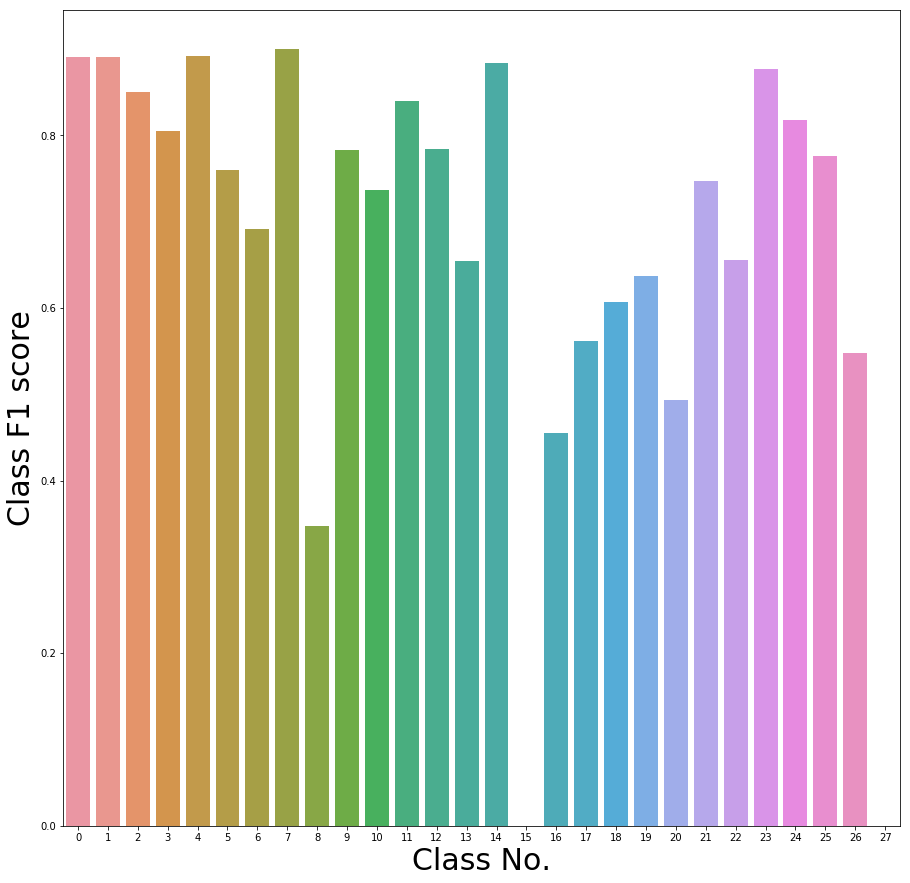

In [21]:
plt.figure(figsize=(15,15))
sns.barplot(x=np.arange(28),y=class_F1)
plt.xlabel('Class No.',fontsize=30)
plt.ylabel('Class F1 score',fontsize=30)
print('Good examples:')
print('class',4,': ',label_names[4])
print('class',7,': ',label_names[7])
print('Bad examples:')
print('class',15,': ',label_names[15])
print('class',27,': ',label_names[27])

Representative images from each of the class of Nuclear speckles, Golgi apparatus, Microtubule ends, Rods & rings.

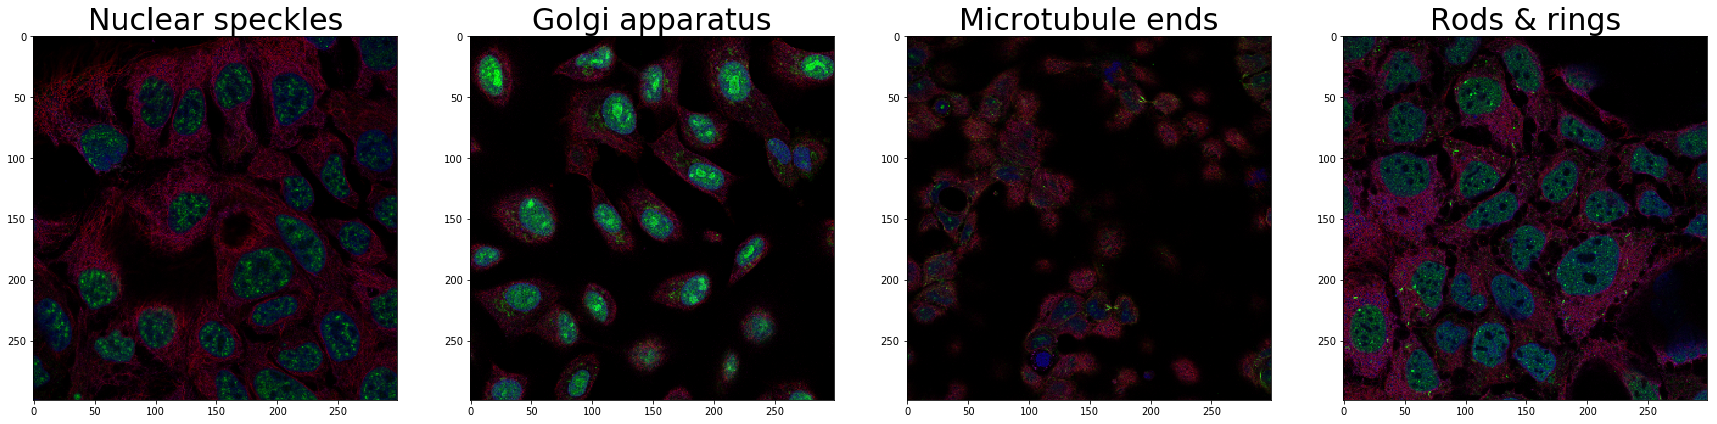

In [22]:
imagelist = ['samples/a4112e46-bbb2-11e8-b2ba-ac1f6b6435d0','samples/b1d943c2-bbb9-11e8-b2ba-ac1f6b6435d0',
            'samples/b0b13c66-bbaa-11e8-b2ba-ac1f6b6435d0','samples/082a828a-bbbb-11e8-b2ba-ac1f6b6435d0']
classno = [4,7,15,27]
images = []
for path in imagelist:
    images.append(data_generator.load_image(path, (SIZE,SIZE,3))/255.)
fig, ax = plt.subplots(1,4,figsize=(30,8))
for i in range(4):
    ax[i].set_title(label_names[classno[i]],fontsize=30)
    ax[i].imshow(images[i])

To understand why the network have poor prediction on certain classes, one can look at the class activation map (CAM) of the output layer. The idea is to vary certain sample images and see for a particular class, which regions of the images produce a stronger activation for the prediciton of that class. Spatial information is usually extracted from the nearest convolutional layer to the output layer. 

<Figure size 432x288 with 0 Axes>

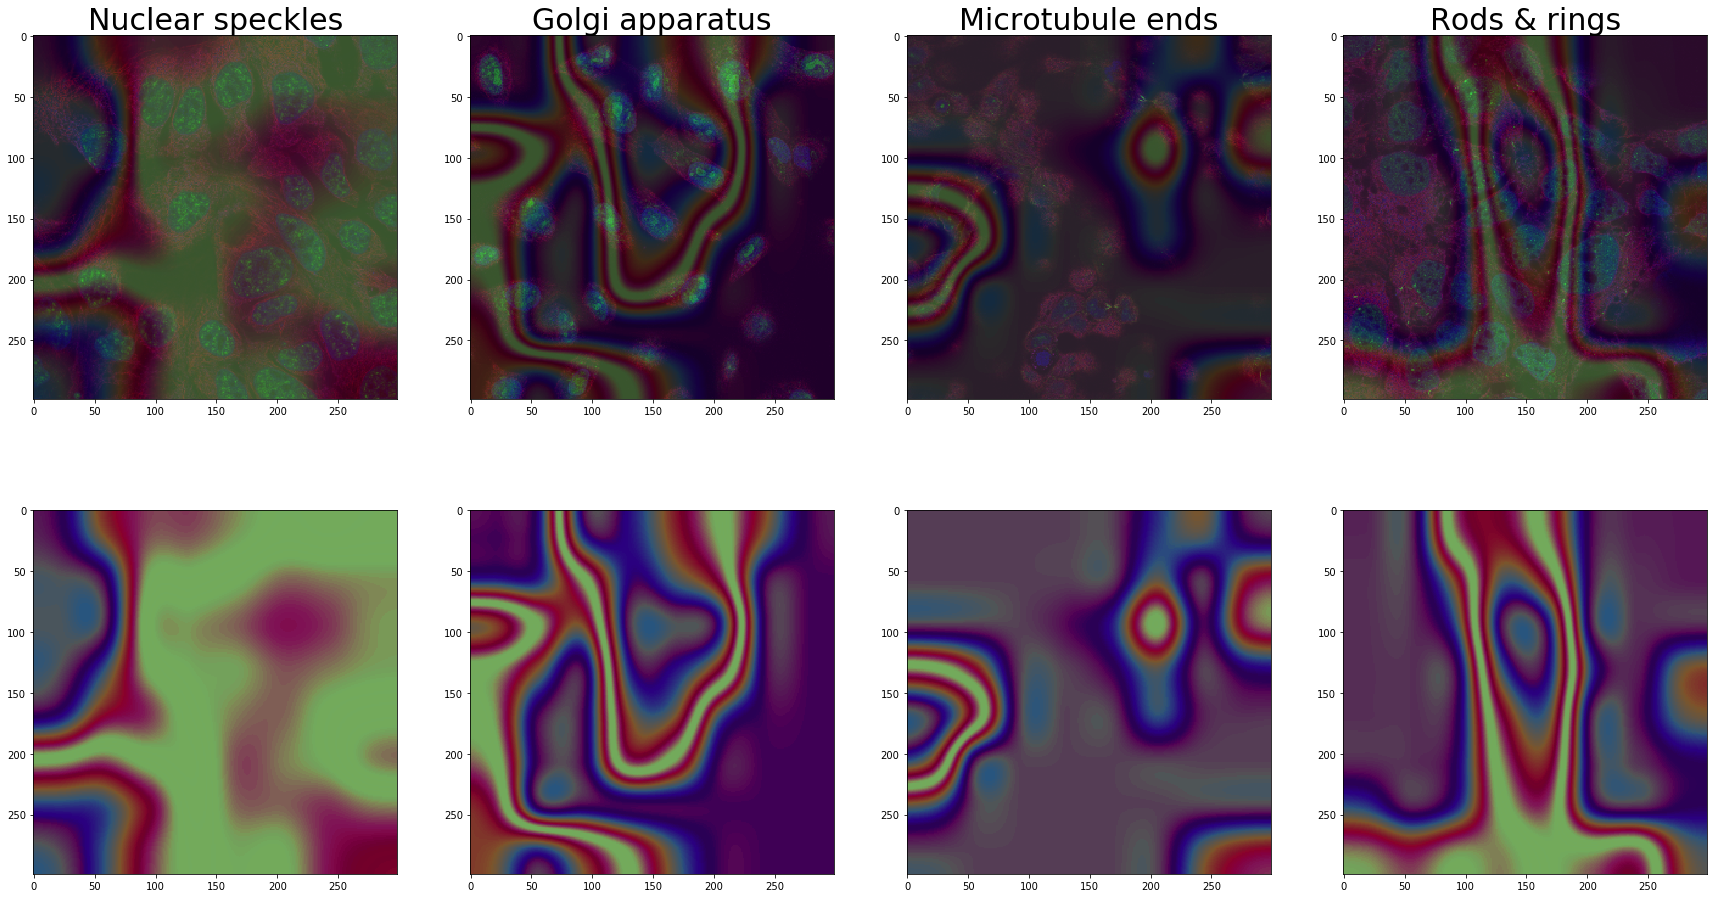

In [23]:
from vis.visualization import visualize_cam, overlay
from vis.utils import utils

penultimate_layer = None
out_layer = 8

plt.figure()

fig, ax = plt.subplots(2,4,figsize=(30,16))

for i in range(4):
    img = data_generator.load_image(imagelist[i], (SIZE,SIZE,3))/255.
    grads = visualize_cam(model, out_layer, filter_indices=classno[i], 
                            seed_input=img, penultimate_layer_idx=penultimate_layer,
                            backprop_modifier=None)  
    # overlay the heatmap onto original image.  
    jet_heatmap = np.mean(cm.jet(grads),axis=-2)
    jet_heatmap = jet_heatmap[:,:,0:3]
    jet_heatmap = np.uint8(jet_heatmap*255.)
    ax[0][i].set_title(label_names[classno[i]],fontsize=30)
    ax[0][i].imshow(overlay(jet_heatmap, img*255))
    ax[1][i].imshow(jet_heatmap)  